In [1]:
import os
import matplotlib.pyplot as plt
HOME = os.getcwd()
print(HOME)

/home/rgildin/pmy/track_and_count_people


In [2]:
SOURCE_VIDEO_PATH = os.path.join(HOME,"data/public_walk.mp4")
TARGET_VIDEO_PATH = SOURCE_VIDEO_PATH.replace(".mp4","_output.mp4")

In [3]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.5 🚀 Python-3.10.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Setup complete ✅ (20 CPUs, 31.2 GB RAM, 64.7/250.9 GB disk)


In [4]:
import supervision as sv
import numpy as np
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.17.0


In [5]:
from ultralytics import YOLO
MODEL = "yolov8x.pt"
model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [6]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - person
selected_classes = [0]

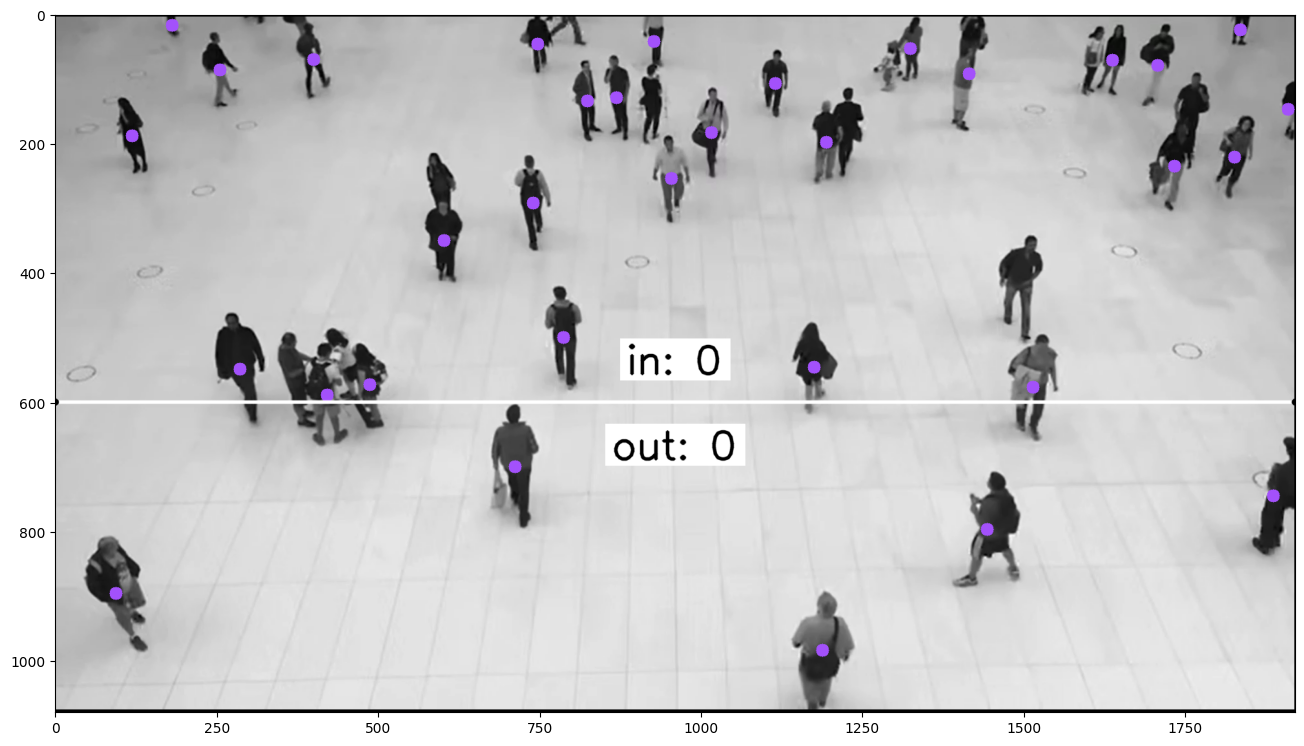

In [7]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
# box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=0, text_scale=.5)
dot_annotator = sv.DotAnnotator(radius=10)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False,device='0',conf=.01, iou=.02)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]

# annotate and display frame
# anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)
anotated_frame=dot_annotator.annotate(scene=frame, detections=detections)

LINE_START = sv.Point(0,  600)
LINE_END = sv.Point(1920, 600)
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)
anotated_frame = line_zone_annotator.annotate(anotated_frame, line_counter=line_zone)

plt.figure(figsize=(16, 16))
plt.imshow(anotated_frame[..., ::-1])
plt.axis('on')
plt.show()

In [8]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.05, track_buffer=30, match_thresh=0.8, frame_rate=24)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
# box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=0, text_scale=.5)
dot_annotator = sv.DotAnnotator(radius=10)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False,device='0',conf=.01, iou=.02)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, tracker_id
        in detections
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    # annotated_frame=box_annotator.annotate(
    #     scene=annotated_frame,
    #     detections=detections,
    #     labels=labels)
    
    annotated_frame=dot_annotator.annotate(scene=frame, detections=detections)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    final_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
    
    # plt.figure(figsize=(16, 16))
    # plt.imshow(final_frame[..., ::-1])
    # plt.axis('on')
    # plt.show()
    
    return final_frame

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)